In [52]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multidist_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle

In [53]:
# loading notes csv
notes = pd.read_csv('notes.csv')

In [54]:
notes

,Sno,Laser dist,Tape dist
0,0,30.9,30
1,1,70.3,70
2,2,109.8,110
3,3,150.2,150
4,4,190.4,190


In [55]:
print(float(notes[notes['Sno']==0]['Laser dist'].iloc[0]))
print(float(notes[notes['Sno']==0]['Tape dist'].iloc[0]))


30.9
30.0


In [56]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    laser_dist=float(notes[notes['Sno']==dist_idx]['Laser dist'].iloc[0])
    tape_dist=float(notes[notes['Sno']==dist_idx]['Tape dist'].iloc[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        # Add new columns to _df for all rows
        _df['Run Exp Num'] = dist_idx
        _df['Laser dist'] = laser_dist/100
        _df['Tape dist'] = tape_dist/100
        if df_all is None:
            df_all=_df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)

df_all

0.df
1.df
2.df
3.df
4.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs,Laser dist,Tape dist
0,Tag1,Tag2,1.756677e+09,1.756677e+09,"[100.21, 134.85, 134.47, 134.32, 134.78, 134.7...",775,0,5,0.309,0.3
1,Tag2,Tag1,1.756677e+09,1.756677e+09,"[205.04, 43.45, 43.3, 43.45, 43.37, 43.45, 43....",775,0,5,0.309,0.3
2,Tag1,Tag2,1.756677e+09,1.756677e+09,"[134.62, 280.5, 280.5, 280.5, 280.88, 280.73, ...",785,0,5,0.309,0.3
3,Tag2,Tag1,1.756677e+09,1.756677e+09,"[39.48, 89.15, 89.38, 89.61, 89.46, 89.53, 89....",785,0,5,0.309,0.3
4,Tag1,Tag2,1.756677e+09,1.756677e+09,"[280.58, 435.0, 435.23, 435.61, 435.99, 435.38...",795,0,5,0.309,0.3
...,...,...,...,...,...,...,...,...,...,...
225,Tag2,Tag1,1.756679e+09,1.756679e+09,"[23.16, 11.86, 12.17, 11.86, 11.86, 11.94, 11....",975,4,5,1.904,1.9
226,Tag1,Tag2,1.756679e+09,1.756679e+09,"[11.1, 11.48, 11.33, 11.25, 11.48, 11.41, 11.4...",985,4,5,1.904,1.9
227,Tag2,Tag1,1.756679e+09,1.756679e+09,"[11.41, 4.92, 4.84, 4.84, 4.84, 4.84, 4.84, 4....",985,4,5,1.904,1.9
228,Tag1,Tag2,1.756679e+09,1.756679e+09,"[11.48, 3.78, 3.7, 3.62, 3.78, 3.7, 3.62, 3.7,...",995,4,5,1.904,1.9


In [57]:
df_all.to_csv('del.csv')

In [58]:
time_per_phase = 10/1000  # s
num_phases=6
num_mpps=df_all.iloc[0]['NumMPPs']
sampling_rate=1000
plotting=False
ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
                                "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])

if plotting:
    plt.figure(figsize=(15,20))

unique_exp_no=0
phase_order=[1,3,4,6,7,8]

for df_idx in range(len(df_all)):

    voltages=df_all.iloc[df_idx]['Voltages (mV)']
    phase_medians={
        1:[],
        3:[],
        4:[],
        6:[],
        7:[],
        8:[],
    }
    for idx,v in enumerate(ver_lines):
        if idx<len(ver_lines)-1:
            phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
        if plotting:
            plt.subplot(len(df_all)//3+1, 3, df_idx+1)
            if idx%num_phases==0:
                plt.axvline(x=v, color='b', linestyle='-')
            else:
                plt.axvline(x=v, color='r', linestyle='--')
    entry={
        "Rx": df_all.iloc[df_idx]["Rx"],
        "Tx":df_all.iloc[df_idx]["Tx"],
        "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
        "Phase1":phase_medians[1],
        "Phase3":phase_medians[3],
        "Phase4":phase_medians[4],
        "Phase6":phase_medians[6],
        "Phase7":phase_medians[7],
        "Phase8":phase_medians[8],
        "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
        "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
        "Tape Dist (m)":df_all.iloc[df_idx]["Tape dist"],
        "Laser Dist (m)":df_all.iloc[df_idx]["Laser dist"],
        "Dist (m)":df_all.iloc[df_idx]["Laser dist"],
        "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
    }
    for phase in phase_order:
        entry_aggregated={
            "Rx":df_all.iloc[df_idx]["Rx"],
            "Tx":df_all.iloc[df_idx]["Tx"],
            "phase": str(phase),
            "median": np.mean(phase_medians[phase]), # mean of medians
            "std": np.std(phase_medians[phase]),
            "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
            "dist":df_all.iloc[df_idx]["Laser dist"],
            'delta': max(phase_medians[phase])-min(phase_medians[phase]),
            "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
            "Unique Exp Number":unique_exp_no,
            "allVoltages": phase_medians[phase]
        }
        processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
    unique_exp_no+=1
    
    # Identify and print bad MPPs
    bad=False
    for k in phase_medians.keys():
        assert(len(phase_medians[k])==num_mpps)
        if np.std(phase_medians[k])>1:
            print(f"<== Bad data found at {df_idx} df_idx at phase {k}.", end="\t")
            print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
    
    processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    if plotting:
        plt.plot(voltages,'.')
        plt.title(df_idx)
        plt.tight_layout()
        
if plotting:
    plt.show()
    
    

/var/folders/hm/7p8fzz2x2y10pbydpxcs7vw00000gn/T/ipykernel_98083/2011979895.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)


In [59]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs,Tape Dist (m),Laser Dist (m),Dist (m)
0,Tag1,Tag2,"[100.21, 134.85, 134.47, 134.32, 134.78, 134.7...","[134.62, 134.62, 134.7, 134.47, 134.585]","[135.16, 135.12, 135.04000000000002, 135.195, ...","[140.04, 140.19, 140.04, 140.04, 140.0]","[141.79, 141.57, 141.72, 141.57, 141.524999999...","[137.41, 137.06, 137.22, 137.14, 137.255]","[134.66, 134.55, 134.47, 134.62, 134.85]",775,0,5,0.3,0.309,0.309
1,Tag2,Tag1,"[205.04, 43.45, 43.3, 43.45, 43.37, 43.45, 43....","[43.45, 43.37, 43.37, 43.45, 43.45]","[42.724999999999994, 42.724999999999994, 42.84...","[44.94, 44.86, 45.05, 44.9, 44.94]","[45.855000000000004, 45.894999999999996, 46.00...","[42.495000000000005, 42.46, 42.53, 42.38500000...","[39.48, 39.48, 39.48, 39.519999999999996, 39.41]",775,0,5,0.3,0.309,0.309
2,Tag1,Tag2,"[134.62, 280.5, 280.5, 280.5, 280.88, 280.73, ...","[280.73, 281.03, 280.96, 280.91999999999996, 2...","[282.56, 282.48, 282.405, 282.52, 282.33]","[294.19500000000005, 294.155, 294.080000000000...","[293.43, 293.735, 293.24, 293.735, 293.47]","[285.495, 285.61, 285.31, 285.455, 285.38]","[280.96, 280.8, 280.765, 280.765, 280.88]",785,0,5,0.3,0.309,0.309
3,Tag2,Tag1,"[39.48, 89.15, 89.38, 89.61, 89.46, 89.53, 89....","[89.46, 89.46, 89.61, 89.53, 89.46]","[88.46, 88.425, 88.425, 88.5, 88.58000000000001]","[92.32, 92.51, 92.32, 92.43, 92.58]","[95.03, 95.18, 95.14, 95.1, 95.065]","[85.95, 85.95, 85.95, 85.95, 85.83000000000001]","[84.11500000000001, 84.455, 84.27, 84.535, 84.38]",785,0,5,0.3,0.309,0.309
4,Tag1,Tag2,"[280.58, 435.0, 435.23, 435.61, 435.99, 435.38...","[435.38, 435.72, 435.38, 435.72, 435.645]","[438.08500000000004, 437.59, 438.045, 438.1649...","[454.185, 454.53, 454.605, 454.45, 454.26]","[447.81, 447.28, 447.66, 447.625, 447.65999999...","[439.805, 439.42, 439.69, 439.575, 439.35]","[435.45, 435.645, 435.23, 435.53, 435.3]",795,0,5,0.3,0.309,0.309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Tag2,Tag1,"[23.16, 11.86, 12.17, 11.86, 11.86, 11.94, 11....","[11.86, 11.86, 11.825, 11.825, 11.79]","[11.52, 11.48, 11.56, 11.56, 11.600000000000001]","[11.825, 11.675, 11.71, 11.71, 11.48]","[11.71, 11.56, 11.56, 11.52, 11.52]","[11.48, 11.56, 11.56, 11.485, 11.48]","[11.52, 11.56, 11.715, 11.52, 11.48]",975,4,5,1.9,1.904,1.904
226,Tag1,Tag2,"[11.1, 11.48, 11.33, 11.25, 11.48, 11.41, 11.4...","[11.41, 11.41, 11.41, 11.445, 11.48]","[11.41, 11.33, 11.41, 11.48, 11.48]","[11.48, 11.41, 11.41, 11.48, 11.48]","[11.33, 11.41, 11.41, 11.48, 11.445]","[11.370000000000001, 11.33, 11.41, 11.445, 11.52]","[11.41, 11.41, 11.445, 11.56, 11.56]",985,4,5,1.9,1.904,1.904
227,Tag2,Tag1,"[11.41, 4.92, 4.84, 4.84, 4.84, 4.84, 4.84, 4....","[4.84, 4.84, 4.84, 4.84, 4.96]","[4.84, 4.84, 4.84, 4.84, 5.38]","[4.84, 4.84, 4.84, 4.84, 5.19]","[4.84, 4.84, 4.84, 4.84, 5.07]","[4.84, 4.84, 4.84, 5.035, 5.19]","[4.84, 4.84, 4.84, 5.11, 5.15]",985,4,5,1.9,1.904,1.904
228,Tag1,Tag2,"[11.48, 3.78, 3.7, 3.62, 3.78, 3.7, 3.62, 3.7,...","[3.7, 3.78, 3.78, 3.78, 3.78]","[3.85, 3.815, 3.815, 3.78, 3.78]","[3.78, 3.7, 3.7, 3.7, 3.78]","[3.74, 3.78, 3.78, 3.74, 3.815]","[3.78, 3.78, 3.78, 3.78, 3.78]","[3.78, 3.78, 3.85, 3.78, 3.85]",995,4,5,1.9,1.904,1.904


In [60]:
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,Tag1,Tag2,1,134.599,0.074726,775000000.0,0.309,0.230,0,0,"[134.62, 134.62, 134.7, 134.47, 134.585]"
1,Tag1,Tag2,3,135.135,0.053104,775000000.0,0.309,0.155,0,0,"[135.16, 135.12, 135.04000000000002, 135.195, ..."
2,Tag1,Tag2,4,140.062,0.065848,775000000.0,0.309,0.190,0,0,"[140.04, 140.19, 140.04, 140.04, 140.0]"
3,Tag1,Tag2,6,141.635,0.101784,775000000.0,0.309,0.265,0,0,"[141.79, 141.57, 141.72, 141.57, 141.524999999..."
4,Tag1,Tag2,7,137.217,0.117712,775000000.0,0.309,0.350,0,0,"[137.41, 137.06, 137.22, 137.14, 137.255]"
...,...,...,...,...,...,...,...,...,...,...,...
1375,Tag2,Tag1,3,5.776,0.059867,995000000.0,1.904,0.160,4,229,"[5.76, 5.68, 5.76, 5.84, 5.84]"
1376,Tag2,Tag1,4,5.797,0.101371,995000000.0,1.904,0.265,4,229,"[5.645, 5.91, 5.76, 5.76, 5.91]"
1377,Tag2,Tag1,6,5.706,0.066813,995000000.0,1.904,0.190,4,229,"[5.8, 5.68, 5.61, 5.68, 5.76]"
1378,Tag2,Tag1,7,5.784,0.048000,995000000.0,1.904,0.120,4,229,"[5.72, 5.76, 5.84, 5.76, 5.84]"


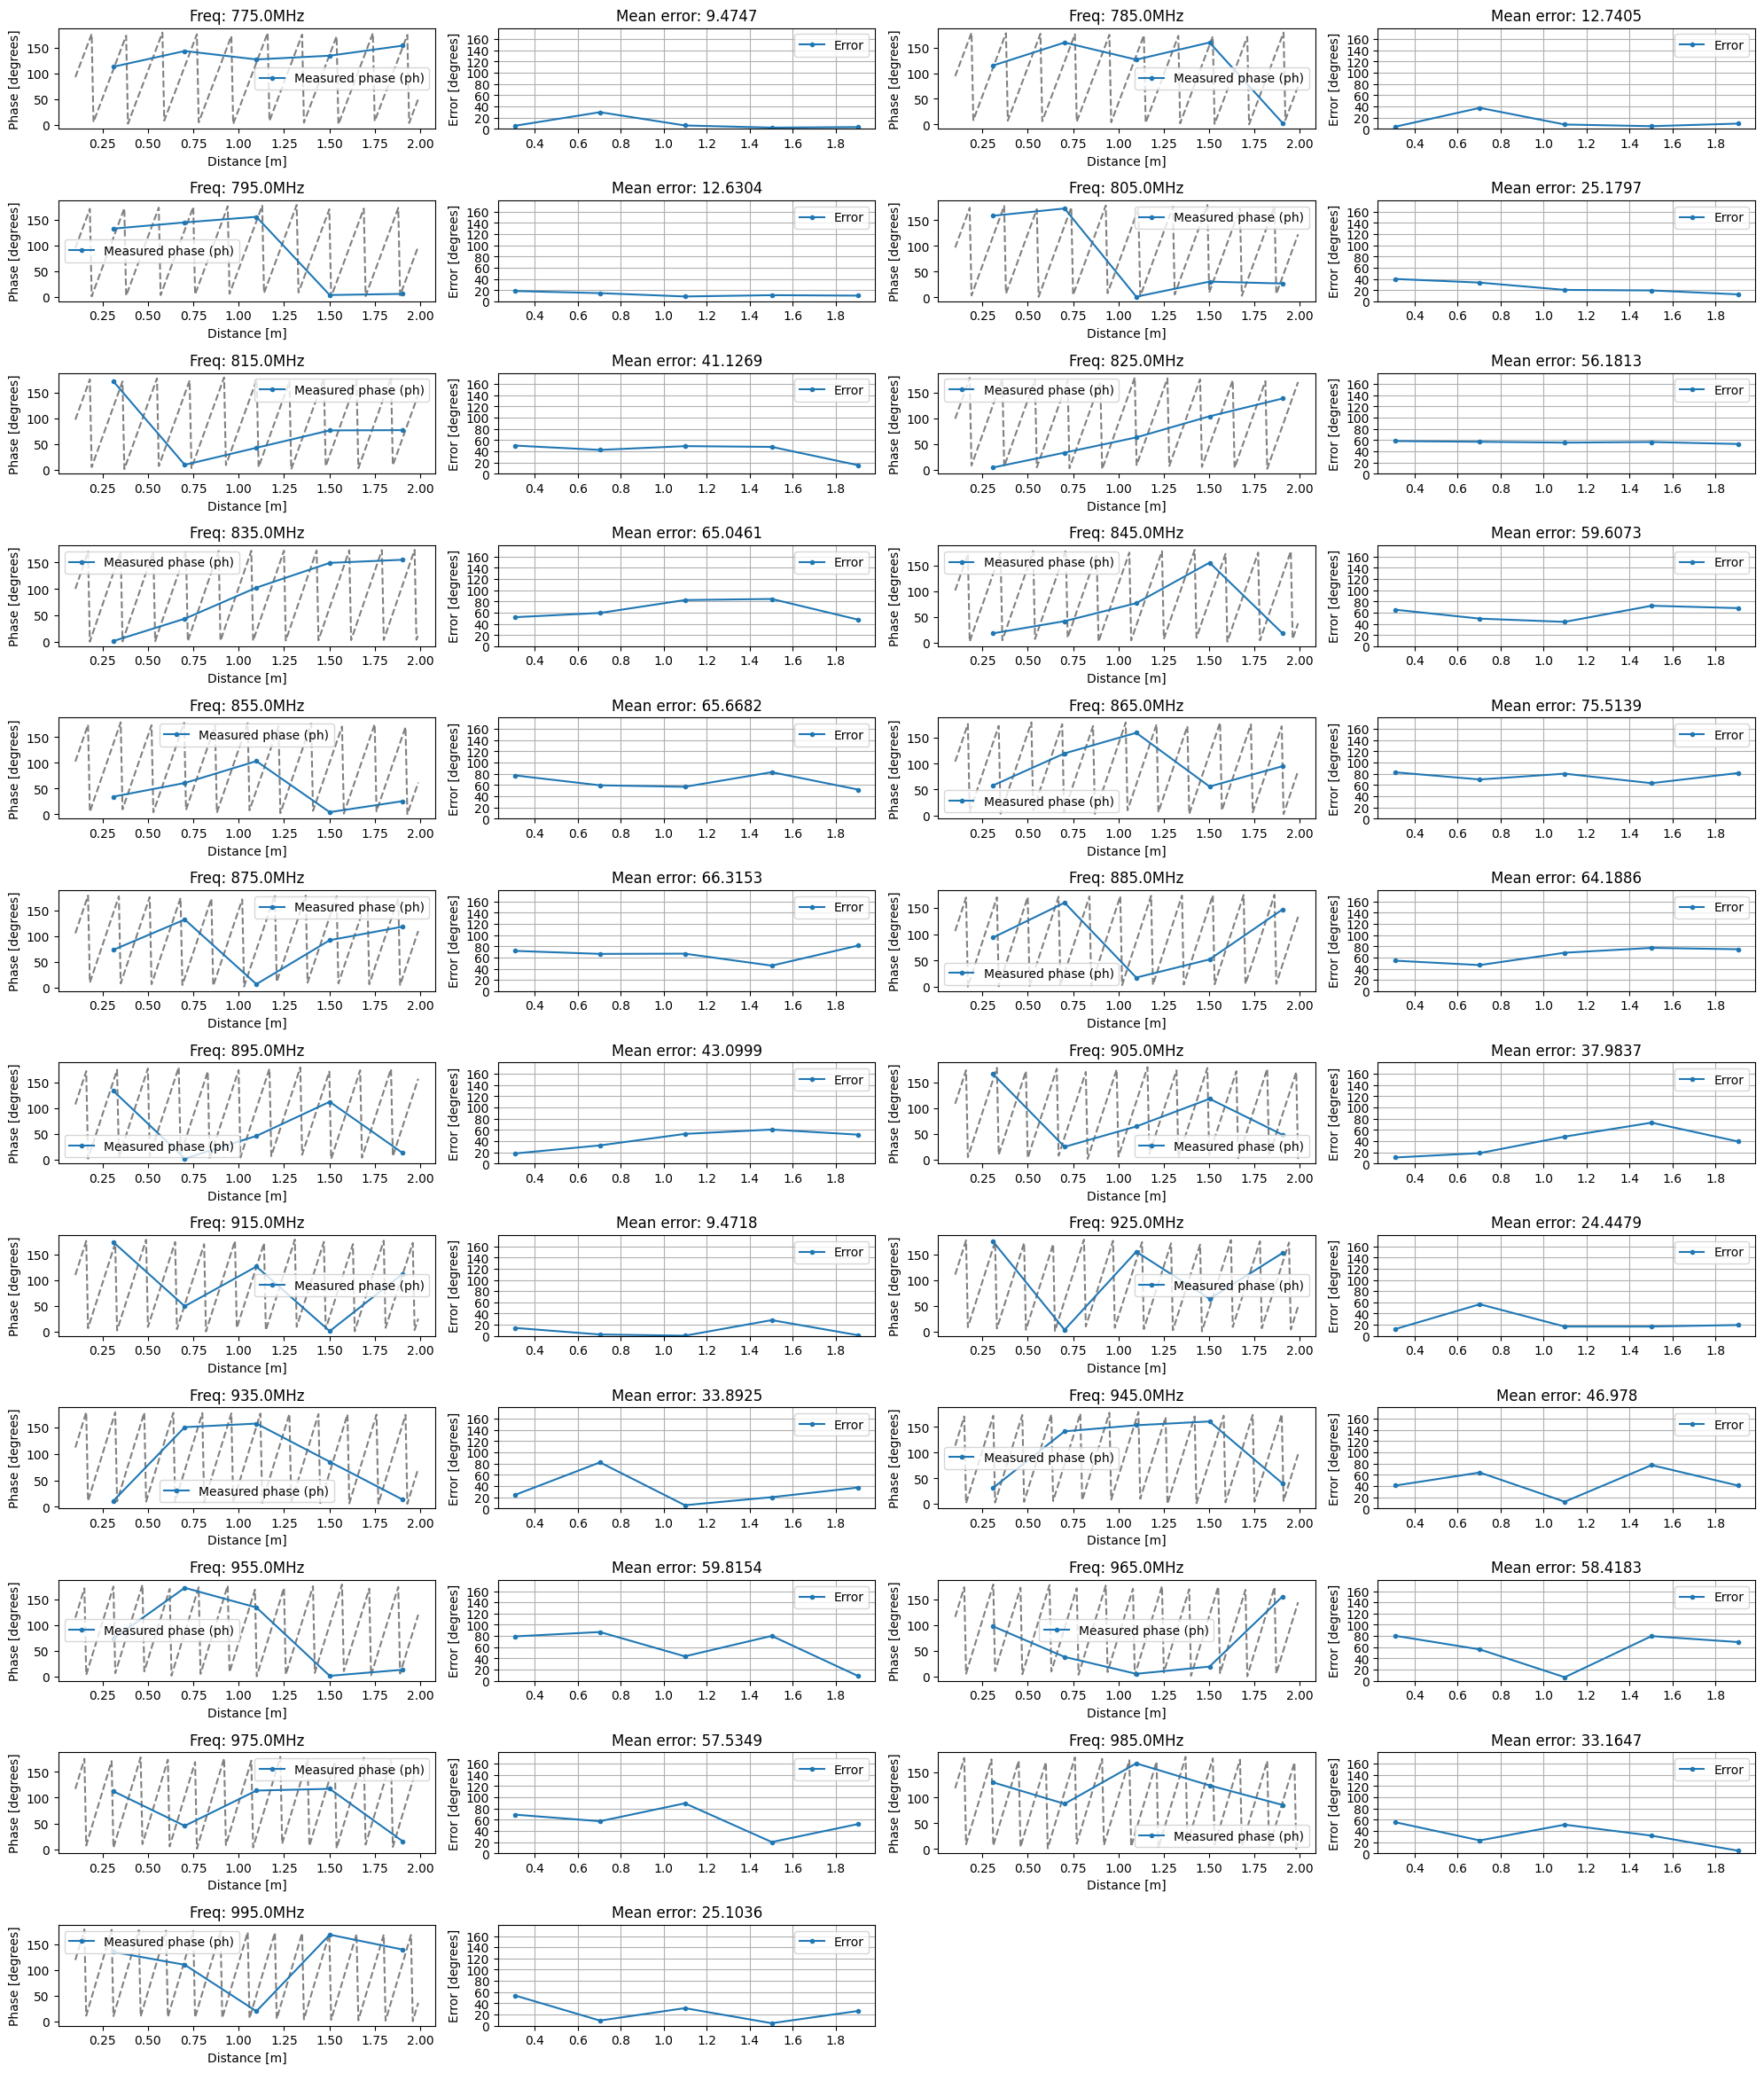

In [61]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors, \
    selected_experiments_all = multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=True)

with open("no_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)

with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

with open("theoretical_phase.pkl",'wb') as f:
    pickle.dump(all_freqs_theoretical,f)  

### With offset correction using the ground truth.

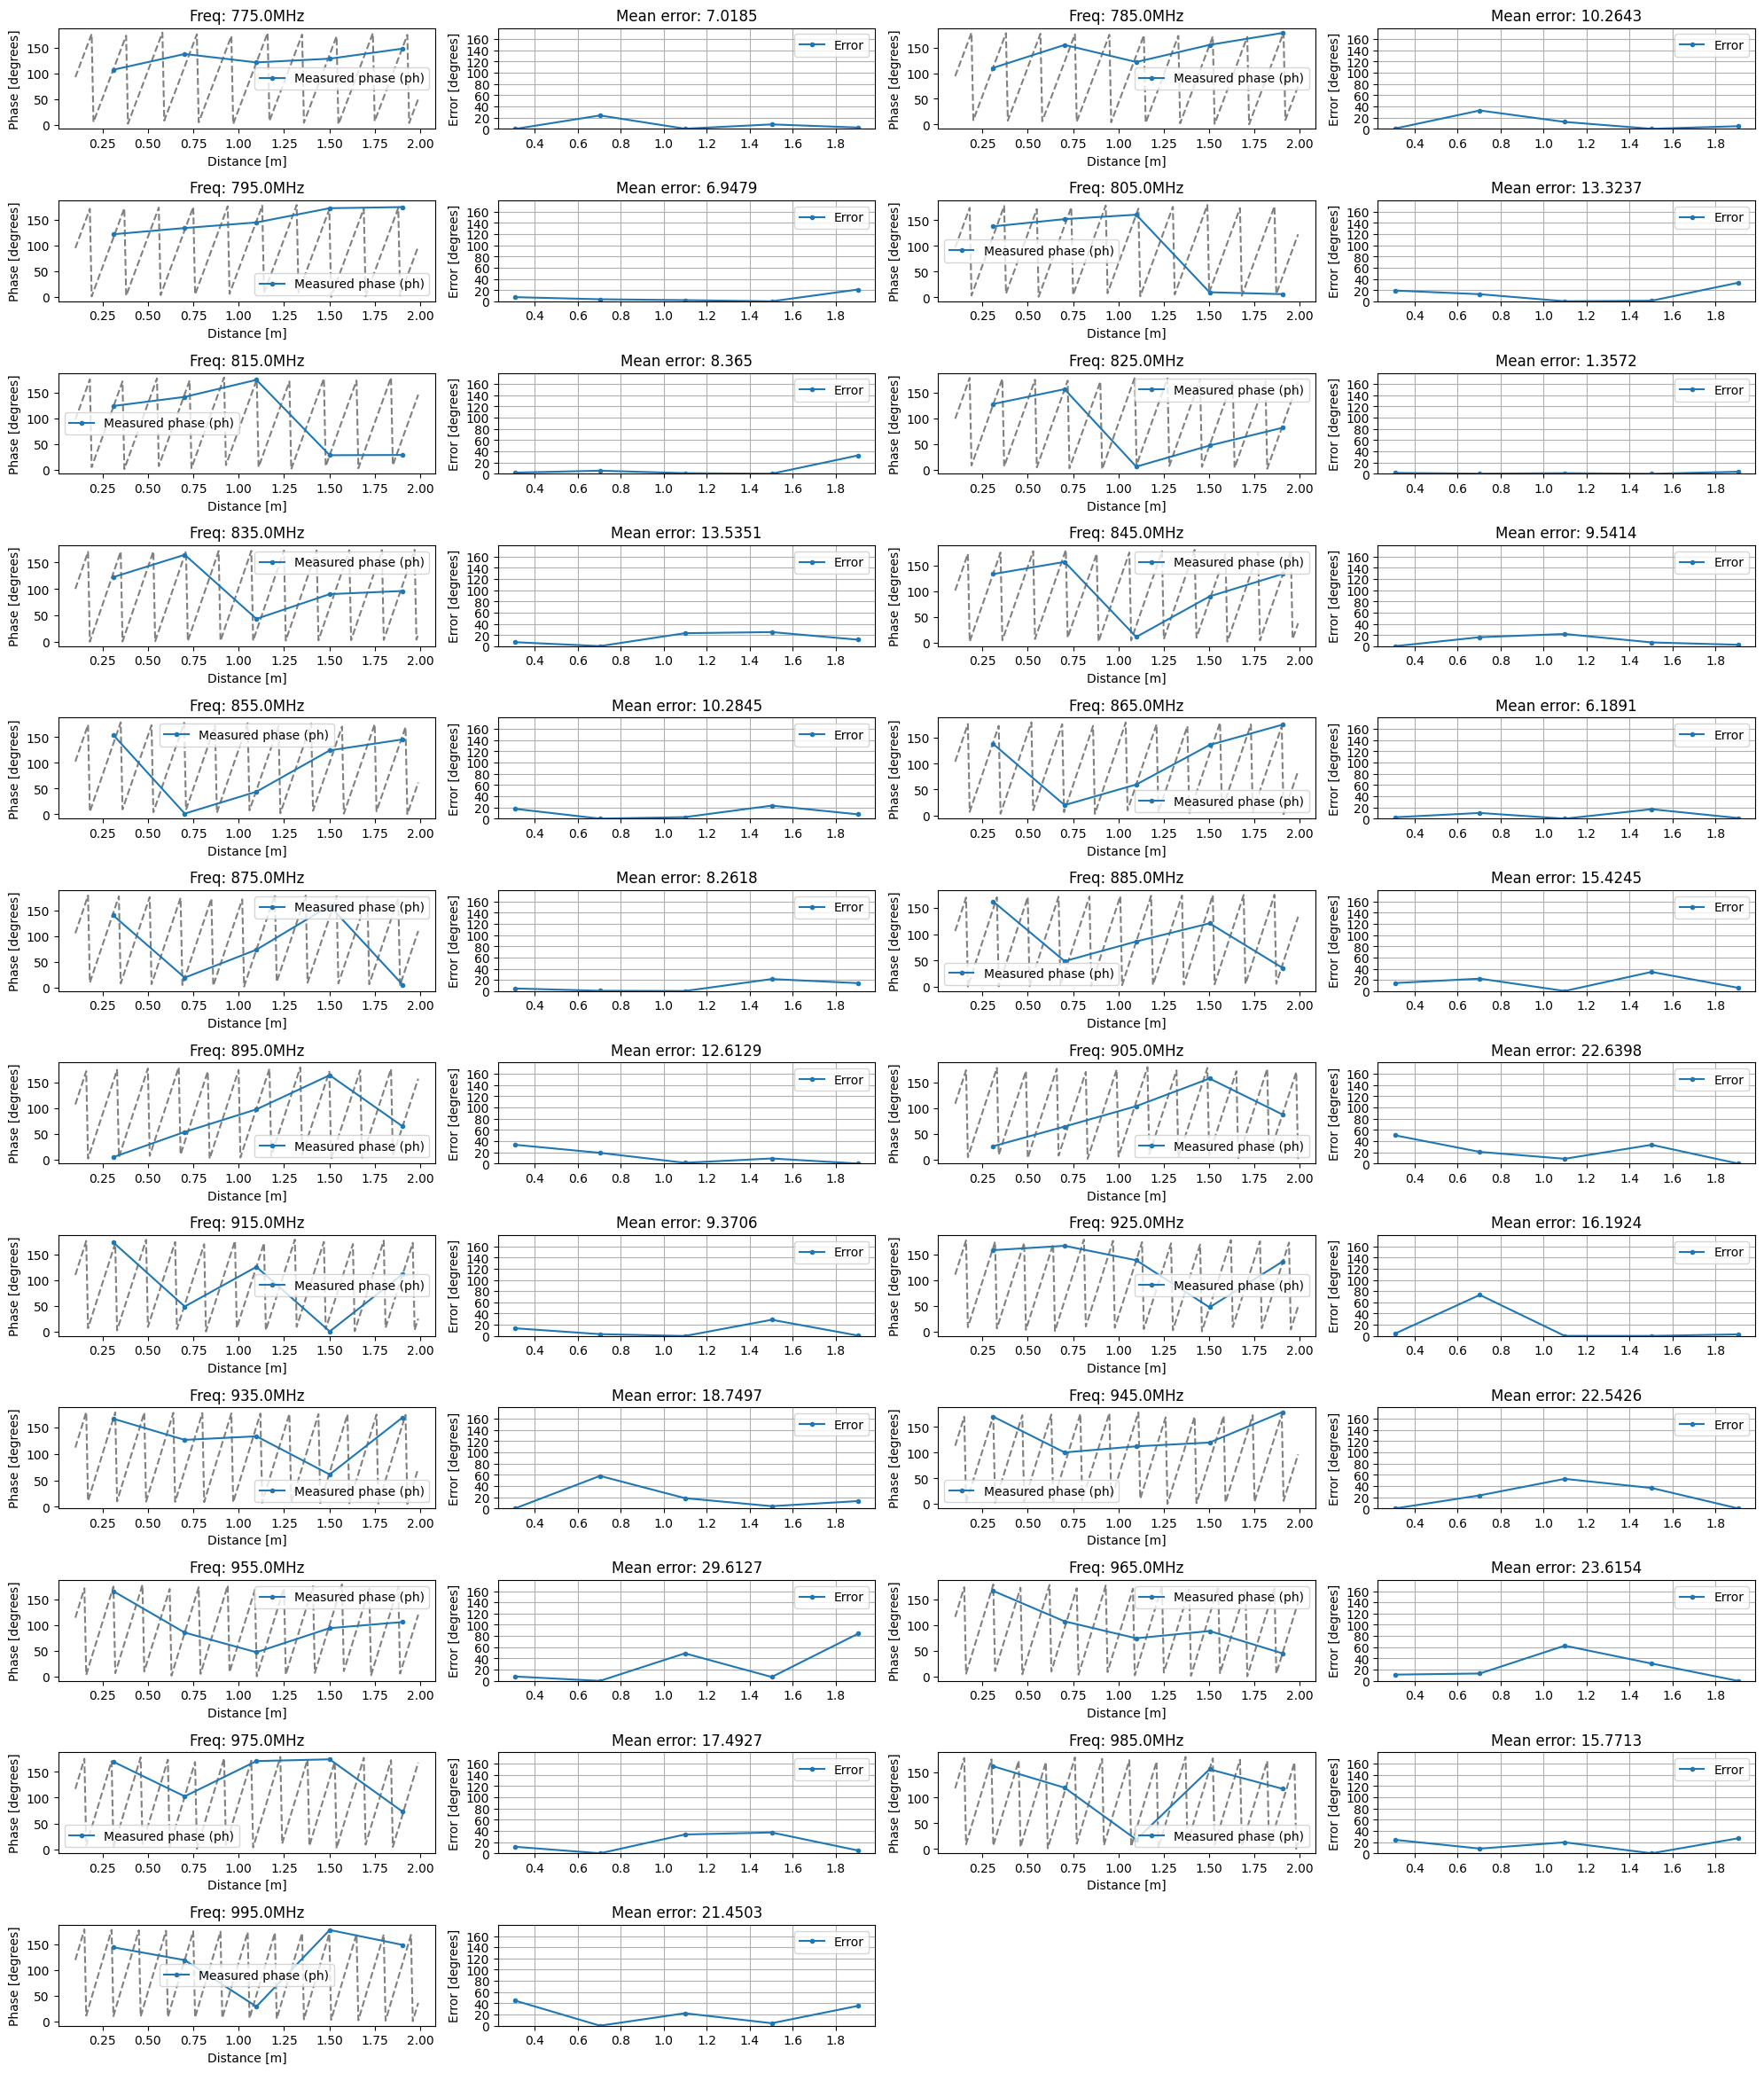

In [62]:
correction_offsets={}
all_errors=None


all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, _,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)


for freq in freq_range:
    offset,best_error,errors=get_offset(all_freqs[freq],freq)
    # print(f"Freq {freq//1e6};\t Mean:{np.mean(errors)};\t Median:{np.median(errors)};\t Std:{np.std(errors)}")
    # if all_errors is None:
    #     all_errors=errors
    # else:
    #     all_errors=np.concat((all_errors,errors))
    correction_offsets[freq]=offset



all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


with open("gt_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("gt_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("gt_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

### With correction offsets from pretrained

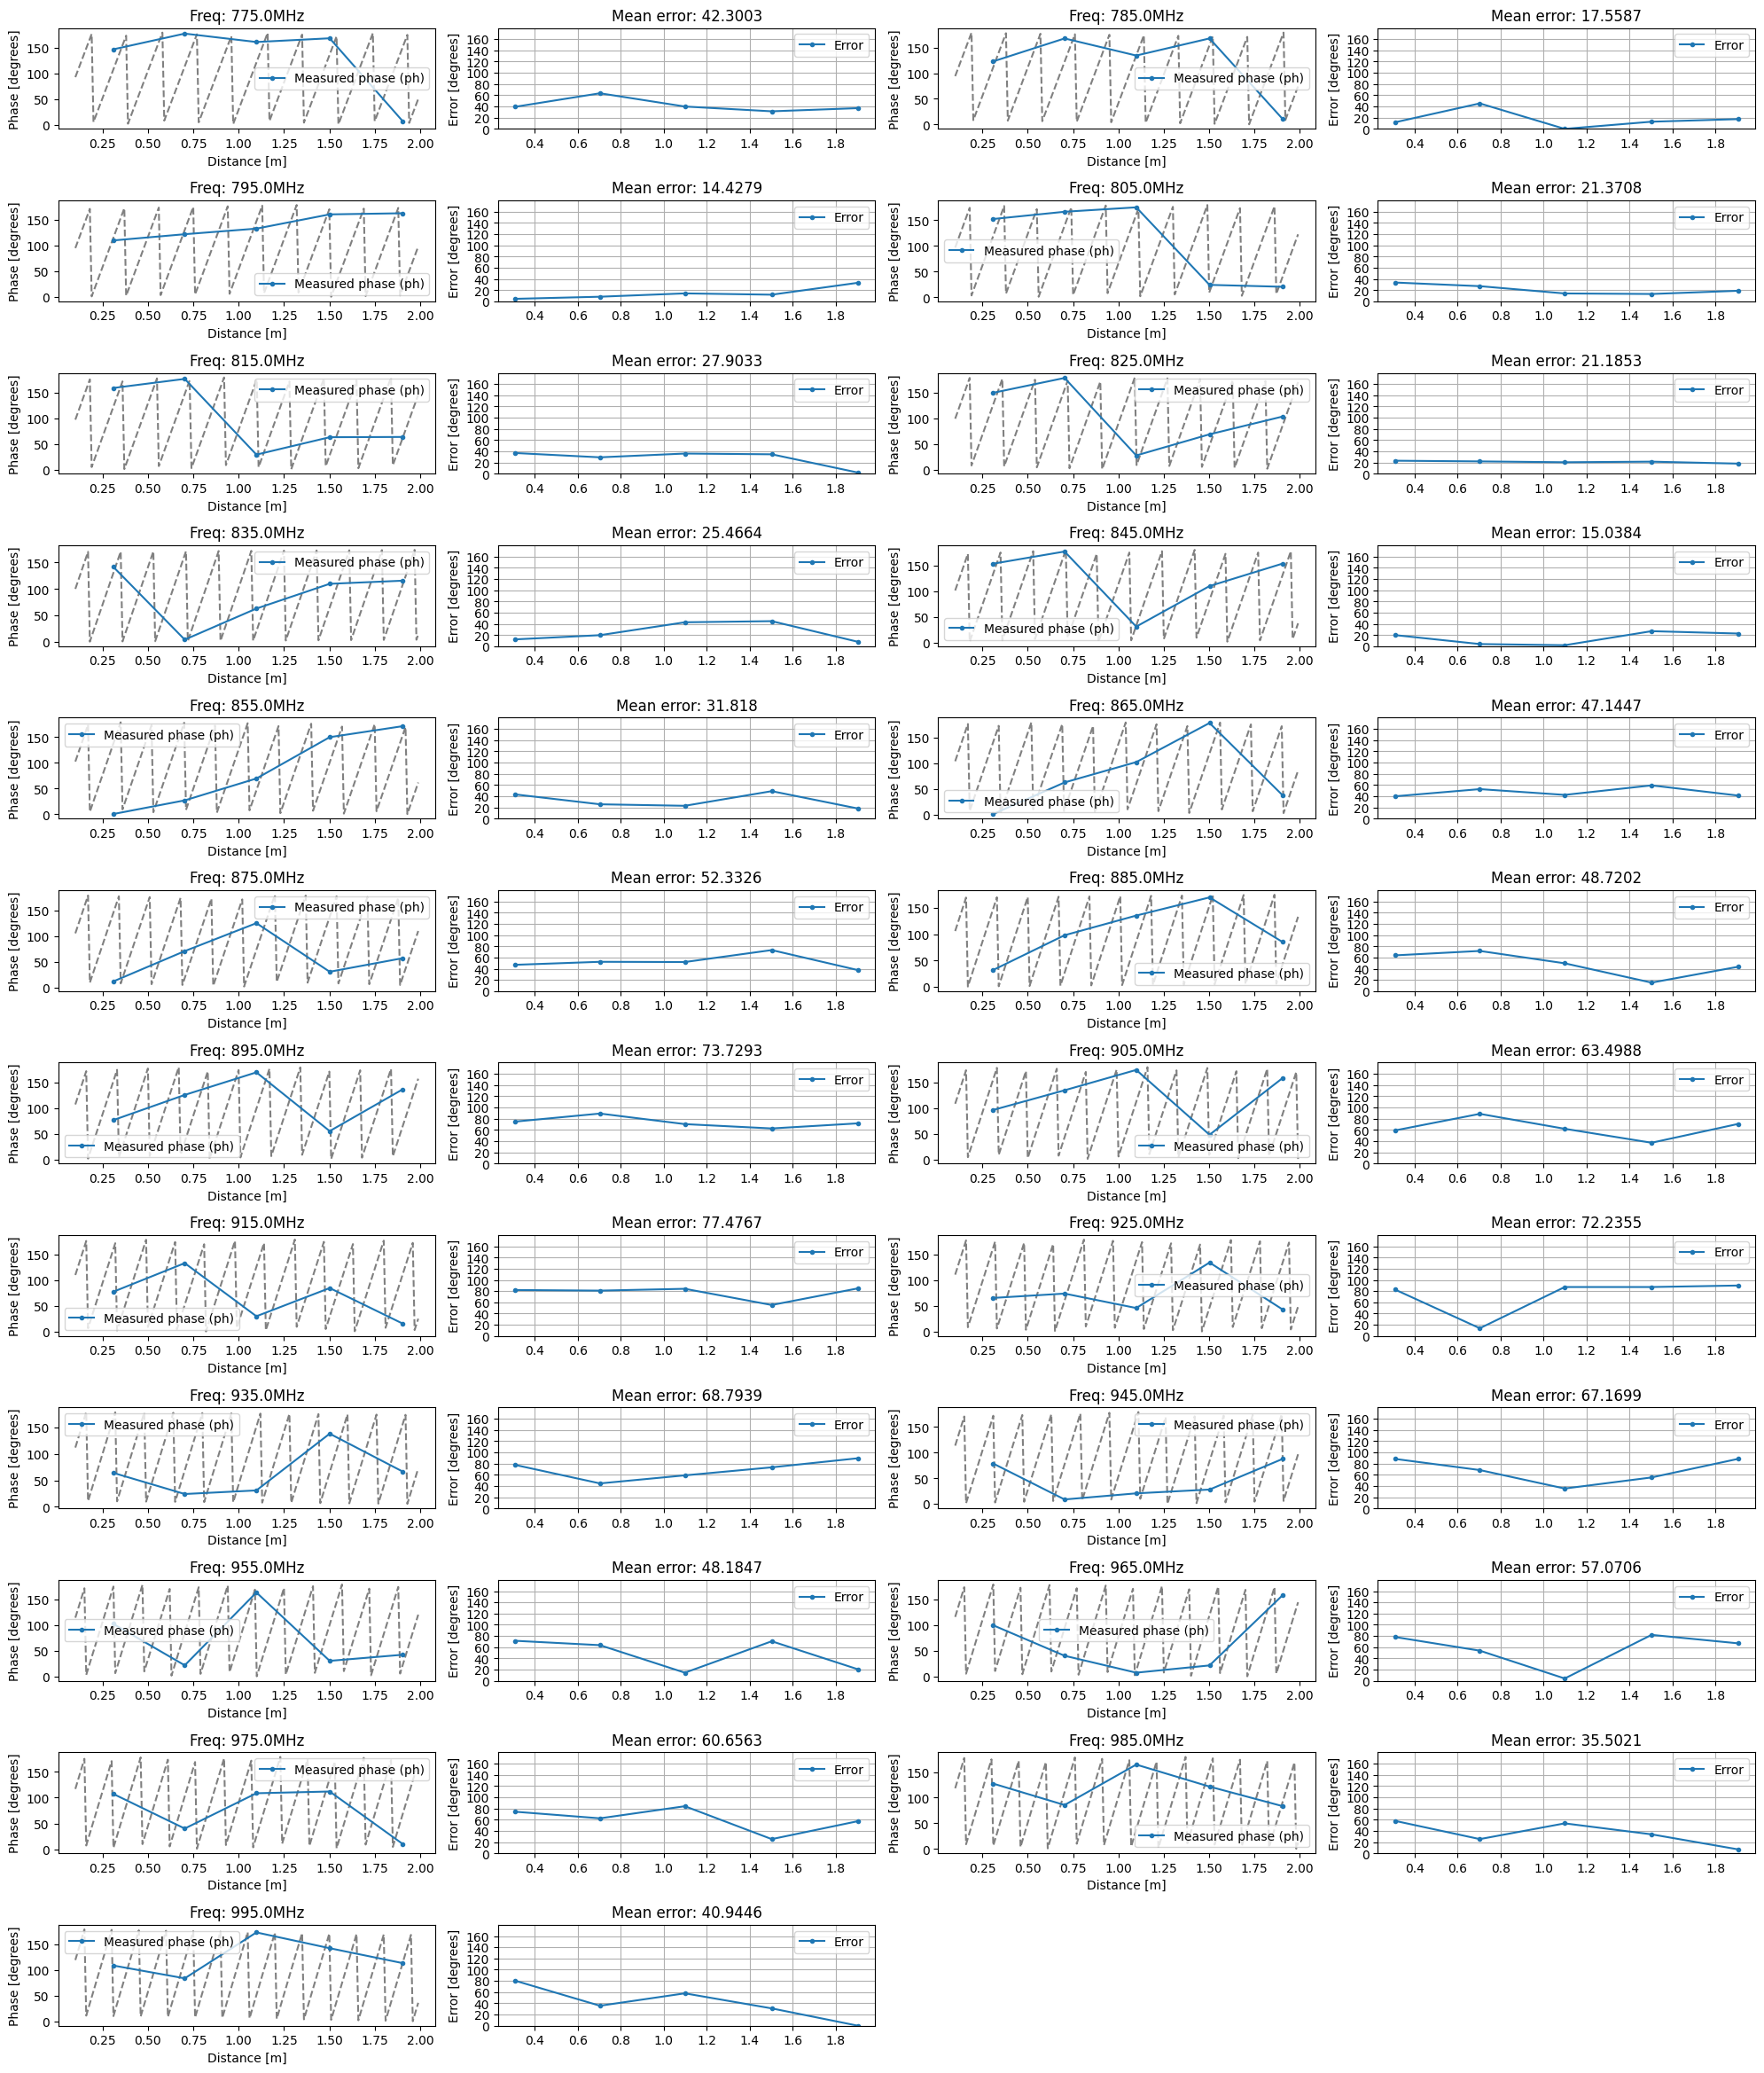

In [63]:
correction_offsets=pickle.load(open("/Users/manavjeet/git/T2TExperiments/DistExperiments/correction_offsets.pkl",'rb'))

all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


with open("pretrained_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("pretrained_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("pretrained_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)